In [1]:
# The PyBullet physics simulation library
import pybullet as p
import pybullet_data as pd

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

# Let's use urdfpy to examine our urdf file before importing into pybullet
from urdfpy import URDF

import time

In [2]:
def mutiground(nums = 14, w = 0.1, h_type = 7, h_low = 0.01, h_height = 0.01):
    """ Create a mutiground environment in a square area
    :param nums: number of tiles of each side of the square
    :param w: with of each tile
    :param h_type: types of height
    :param h_low: lowest height
    :param h_height: highest height
    :return: None
    """
    h_series = np.linspace(h_low, h_height, h_type)
    # compensate = w*nums/2
    compensate = 0
    sh_colBoxex = []
    for i in range(h_type):
        sh_colBox = p.createCollisionShape(p.GEOM_BOX, halfExtents=[w, w, h_series[i]]) #
        sh_colBoxex.append(sh_colBox)
    for i in range(nums):
        for j in range(nums):
            index = np.random.randint(0, h_type)
            groundId =  p.createMultiBody(baseMass=0,baseCollisionShapeIndex = sh_colBoxex[index],
                                          basePosition = [i*w*2-compensate,j*w*2-compensate,0],
                                          baseOrientation=[0,0,0,1])    
    # p.changeDynamics(groundId,-1,lateralFriction = 3000)


def contact():
    tip_z_position = p.getJointState(hopperID,joints['leg_spring'])[0]

    if tip_z_position >0.005: #larger than a value of perturbation
        return True
    else:
        return False


def getVelocity():
    tip_vel = np.array(p.getLinkState(hopperID, 0, links['leg_tip'])[6])

    return tip_vel

def getBodyVelocity():
    Bodyvel = np.array(p.getLinkState(hopperID, 0, links['body'])[6])

    return Bodyvel


IL = 3  # integral len
Velo_Buffer = np.zeros((IL,2))
def getTargetLegDisplacement(kv = 0.014, ki = 0.007, system_error=0):
    vel = getVelocity()[0:2]

    Velo_Buffer[1:] = Velo_Buffer[:-1]
    Velo_Buffer[0] = vel
    
    target_velo = np.array(targetVelocity) + system_error
    vel_error = vel-target_velo
    integral_error = np.sum(Velo_Buffer - target_velo) 

    neutral_point = (vel*stance_duration)/2.0

    disp = neutral_point + kv*vel_error + ki*integral_error
    disp = np.append(disp, -np.sqrt(getLegLength()**2-disp[0]**2-disp[1]**2))
    if np.isnan(disp[2]):
        print('legs too short')
    return disp


def getLegLength():
    return 0.15 - p.getJointState(hopperID,joints['leg_spring'])[0]

def transform_H_to_B(vec): # transform a 4x1 vector in H frame to be expressed in B frame.
                            # H attaches to hip but stays parallel to World
                            # B is fixed with hip for both pos and orientation
    HB_matrix_row_form = p.getMatrixFromQuaternion(p.getBasePositionAndOrientation(hopperID)[1])
    HB_matrix = np.zeros((4,4))
    HB_matrix[3,3]=1
    HB_matrix[0, 0:3] = HB_matrix_row_form[0:3]
    HB_matrix[1, 0:3] = HB_matrix_row_form[3:6]
    HB_matrix[2, 0:3] = HB_matrix_row_form[6:9]

    HB_matrix = np.matrix(HB_matrix)

    BH_matrix = np.linalg.inv(HB_matrix)

    return BH_matrix*vec

def velocityDirControl(velo, state, area, threhold = 0.2):
    """
        area should contain 2 dimensions in this case
    """
    v = []
    for ve in velo:
        v.append(ve)
    for i in range (len(area)):
        if (velo[i] > 0 and state[i] > (1-threhold)*area[i]) or (velo[i] < 0 and state[i] < threhold*area[i]):
            v[i] = -v[i]
    return v

In [3]:
robot = URDF.load('7new_hopper.urdf')

print('Links')
for link in robot.links:
    print(link.name)

print('\r\n')
print('Joints')
for joint in robot.joints:
    print('{} connects {} to {}'.format(
           joint.name, joint.parent, joint.child))  

Links
body
base_link1
base_link2
base_link3
base_link4
mid_link1
mid_link2
mid_link3
mid_link4
cylinder
leg_tip
shin_link


Joints
base1_to_base2 connects base_link1 to base_link2
base1_to_base3 connects base_link1 to base_link3
base1_to_base4 connects base_link1 to base_link4
body_to_base1 connects base_link1 to body
hip_roll connects base_link3 to mid_link1
mid1_mid2_joint connects mid_link1 to mid_link2
mid1_mid3_joint connects mid_link1 to mid_link3
mid1_mid4_joint connects mid_link1 to mid_link4
hip_pitch connects mid_link3 to cylinder
ankle connects leg_tip to shin_link
leg_spring connects cylinder to leg_tip


In [4]:
#-----------Start Setup---------------##########1111111

p.connect(p.GUI)
p.setAdditionalSearchPath(pd.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)



planeID = p.loadURDF("plane.urdf")
p.changeDynamics(planeID,-1,lateralFriction = 100)


hopperID = p.loadURDF("7new_hopper.urdf", [0.5, 0.6, 0.25], [0.00, 0.001, 0, 1])

numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hopperID)
jointInfo = [p.getJointInfo(hopperID, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()]

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()]

#-----------Initial Setting-----------------------------------------------------------------------------------------
k_spring = 2700  # leg spring constant 
state = 0  # 0 -> Stance, 1-> flight
legForce = 10


k_pose_kp = 60
k_pose_kv = 0.01

k_leg_kp = 10
k_leg_kv = 0.5

# Enable Torque Control(Just following the documentation, I find this procedure to be a bit weird though)
p.setJointMotorControl2(hopperID, joints['leg_spring'], p.VELOCITY_CONTROL, force=0)

p.setGravity(0,0,-9.81)
curtime = 0
#dt = 1. / 240.
dt = 0.005


prev_orientation = np.array([0, 0, 0])
count = 0
t = 0
stance_made = False
stance_duration = 0.17 #duration of a single stance phase. updated every stance. 0.17 is just rough value for the first hop.
tip_contact_flag = 1

#initial desire velocity
targetVelocity = np.array([0.15,0.10])

# get the data
leg_state = {'t': [], 'pos': [], 'desire_vel_x': [], 'desire_vel_y': [], 'vel_x_body': [], 'vel_y_body':[]}
Body = {'posx': [], 'posy': [], 'posz': [], 'pos_on_x':[],  'pos_on_y':[], 'tip_contact_x':[], 'tip_contact_y':[]  }

# load the uneven ground
mutiground_nums = 5
width_tile = 0.15
Area = [mutiground_nums*width_tile*2, mutiground_nums*width_tile*2]



mutiground(nums = mutiground_nums, w = width_tile)


state_sample = [0,0]
state_sample[0] = p.getLinkState(hopperID, links['leg_tip'] )[0]

while 1:
    p.resetDebugVisualizerCamera( cameraDistance=0.6, cameraYaw=45, cameraPitch=10, 
                                  cameraTargetPosition=[0.5, 0.6, 1])    #  [0.1+t/1600, 0.1+t/1600, 0.2]
    t+=1
    count = count + 1
    curtime = curtime + dt
    posxx = p.getLinkState(hopperID, links['body'] )[0][0]
    Body['pos_on_x'].append(posxx)
    posyy = p.getLinkState(hopperID, links['body'] )[0][1]
    Body['pos_on_y'].append(posyy)



    
    position = p.getJointState(hopperID,joints['leg_spring'])[0]
    state_sample[1] = p.getLinkState(hopperID, links['leg_tip'] )[0]
    Body['posx'].append(position)


    if contact():
        state = 0 # assignment statement for stance phase

    else:
        state = 1 # assignment statement for flight phase

    
    # monitor if the state changed from flight to stance
    if tip_contact_flag == 1:
        if state == 0:
            # output the value of foot in XoY contact when contact the ground
            tip_contact_xx = p.getLinkState(hopperID, links['leg_tip'] )[0][0]
            tip_contact_yy = p.getLinkState(hopperID, links['leg_tip'] )[0][1]
            Body['tip_contact_x'].append(tip_contact_xx)
            Body['tip_contact_y'].append(tip_contact_yy)
    tip_contact_flag = state
    


    if state == 1: # Flight phase
        stance_made = False
        legForce = -(k_spring) * position
        targetLegDisplacement_H = getTargetLegDisplacement()
        targetLegDisplacement_H = np.append(targetLegDisplacement_H, 1)
        targetLegDisplacement_H = np.matrix(targetLegDisplacement_H)

        targetLegDisplacement_B = transform_H_to_B(targetLegDisplacement_H.T)

        x_disp_B = targetLegDisplacement_B[0, 0]
        y_disp_B = targetLegDisplacement_B[1, 0]

        d = getLegLength()
        theta_pitch_desire = np.arcsin(x_disp_B/d)
        theta_roll_desire = np.arcsin(y_disp_B/(-d*np.cos(theta_pitch_desire)))
        
        
        
        theta_roll, theta_roll_velocity, theta_roll_reactForce, theta_roll_appliedForce = p.getJointState(hopperID, joints['hip_roll'])
        theta_pitch, theta_pitch_velocity, theta_pitch_reactForce, theta_pitch_appliedForce = p.getJointState(hopperID, joints['hip_pitch'])

        torque_roll = - k_leg_kp*(theta_roll - theta_roll_desire) - k_leg_kv*theta_roll_velocity
        torque_pitch = - k_leg_kp*(theta_pitch - theta_pitch_desire) - k_leg_kv*theta_pitch_velocity

        # p.setJointMotorControl2(hopperID,  joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=torque_roll)
        # p.setJointMotorControl2(hopperID,  joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=torque_pitch)

        p.setJointMotorControl2(hopperID, joints['hip_roll'], p.POSITION_CONTROL,
                                targetPosition=theta_roll_desire)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.POSITION_CONTROL,
                                targetPosition=theta_pitch_desire)

    else:  # Stance phase
        if not stance_made:
            stance_made = True
            stance_duration = 0
        stance_duration = stance_duration + dt
        base_orientation = p.getLinkState(hopperID, 1)[1]
        base_orientation_euler = np.array(p.getEulerFromQuaternion(base_orientation))

        orientation_change = base_orientation_euler - prev_orientation
        orientation_velocity = orientation_change / dt

        roll_hip_joint_T = (-k_pose_kp * base_orientation_euler[0] - k_pose_kv * orientation_velocity[0])
        pitch_hip_joint_T = (-k_pose_kp * base_orientation_euler[1] - k_pose_kv * orientation_velocity[1])

        # p.setJointMotorControl2(hopperID, joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=roll_hip_joint_T)
        # p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=pitch_hip_joint_T)

        p.setJointMotorControl2(hopperID, joints['hip_roll'] , p.VELOCITY_CONTROL,
                                targetVelocity=roll_hip_joint_T)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.VELOCITY_CONTROL,
                                targetVelocity=pitch_hip_joint_T)

        prev_orientation = base_orientation_euler


        legForce = (-(k_spring) * position) - 20 #Add additional leg force to compensate for energy lost of the system

    p.setJointMotorControl2(hopperID, joints['leg_spring'], p.TORQUE_CONTROL, force=legForce)
    
    #Print velocity of hopper every steps.
    if count % 1 == 0:
        # print(getVelocity())
        leg_state['vel_x_body'].append(getBodyVelocity()[0])
        leg_state['vel_y_body'].append(getBodyVelocity()[1])
        height =p.getJointState(hopperID,joints['leg_spring'])[0]
        leg_state['pos'].append(height)
        # leg_state['desire_vel_x'].append(vx) 
        # leg_state['desire_vel_y'].append(vy)
        # Body['posx'].append(xbody[0])
        # Body['posy'].append(xbody[1])
        # Body['posz'].append(xbody[2])
        
        targetVelocity = velocityDirControl(targetVelocity, p.getLinkState(hopperID, links['leg_tip'] )[0], Area)



    #break down the simulation
    if count == 4500:
        break
        targetVelocity[0] = 0
        targetVelocity[1] = -0.30

    p.stepSimulation()
    time.sleep(dt)



#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##store the sets of data
sets_x_vel_1 = leg_state['vel_x_body']

sets_y_vel_1 = leg_state['vel_y_body']

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

sets_xy_vel_1 = (x_array_body_vel**2 + y_array_body_vel**2)**0.5

sets_pos_x_1 = Body['pos_on_x']

tip_contact_x_1 = Body['tip_contact_x']
tip_contact_y_1 = Body['tip_contact_y']


Number of bodies: 2
b'plane'
b'hopper'


Joint names:
base1_to_base2
base1_to_base3
hip_roll
mid1_mid2_joint
mid1_mid3_joint
hip_pitch
leg_spring
ankle
mid1_mid4_joint
base1_to_base4
body_to_base1


Link names:
base_link2
base_link3
mid_link1
mid_link2
mid_link3
cylinder
leg_tip
shin_link
mid_link4
base_link4
body


In [5]:
p.getLinkState(hopperID, links['leg_tip'] )[0]

(0.6521391370719833, 0.6897181891083833, 0.018896607115540892)

Text(0, 0.5, 'tip_contact_position')

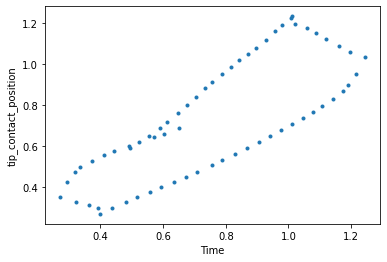

In [6]:
plt.plot(Body['tip_contact_x'], Body['tip_contact_y'],'.')
plt.xlabel('Time')
plt.ylabel('tip_contact_position')

## For now, we are going to derive sets of data of real velocity, which needs 10 individual sets, and then caculate the mean and std

In [7]:
###### Reset sim and reload robots ###########22222222222222222

p.resetSimulation()
p.setAdditionalSearchPath(pd.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

import numpy as np


planeID = p.loadURDF("plane.urdf")
p.changeDynamics(planeID,-1,lateralFriction = 100)


hopperID = p.loadURDF("7new_hopper.urdf", [0.5, 0.6, 0.25], [0.00, 0.001, 0, 1])

numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hopperID)
jointInfo = [p.getJointInfo(hopperID, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()]

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()]

#-----------Initial Setting-----------------------------------------------------------------------------------------
k_spring = 2700  # leg spring constant 
state = 0  # 0 -> Stance, 1-> flight
legForce = 10


k_pose_kp = 60
k_pose_kv = 0.01

k_leg_kp = 10
k_leg_kv = 0.5


# Enable Torque Control(Just following the documentation, I find this procedure to be a bit weird though)
p.setJointMotorControl2(hopperID, joints['leg_spring'], p.VELOCITY_CONTROL, force=0)

p.setGravity(0,0,-9.81)
curtime = 0
#dt = 1. / 240.
dt = 0.005


prev_orientation = np.array([0, 0, 0])
count = 0
t = 0
stance_made = False
stance_duration = 0.17 #duration of a single stance phase. updated every stance. 0.17 is just rough value for the first hop.
tip_contact_flag = 1

#initial desire velocity
targetVelocity = np.array([0.15,0.10])

# get the data
leg_state = {'t': [], 'pos': [], 'desire_vel_x': [], 'desire_vel_y': [], 'vel_x_body': [], 'vel_y_body':[]}
Body = {'posx': [], 'posy': [], 'posz': [], 'pos_on_x':[],  'pos_on_y':[], 'tip_contact_x':[], 'tip_contact_y':[]  }

# load the uneven ground
mutiground_nums = 5
width_tile = 0.15
Area = [mutiground_nums*width_tile*2, mutiground_nums*width_tile*2]



mutiground(nums = mutiground_nums, w = width_tile)


state_sample = [0,0]
state_sample[0] = p.getLinkState(hopperID, links['leg_tip'] )[0]

while 1:
    p.resetDebugVisualizerCamera( cameraDistance=1, cameraYaw=45, cameraPitch=-10, 
                                  cameraTargetPosition=[0.5, 0.2, 0.5])    #  [0.1+t/1600, 0.1+t/1600, 0.2]
    t+=1
    count = count + 1
    curtime = curtime + dt
    posxx = p.getLinkState(hopperID, links['body'] )[0][0]
    Body['pos_on_x'].append(posxx)
    posyy = p.getLinkState(hopperID, links['body'] )[0][1]
    Body['pos_on_y'].append(posyy)



    
    position = p.getJointState(hopperID,joints['leg_spring'])[0]
    state_sample[1] = p.getLinkState(hopperID, links['leg_tip'] )[0]
    Body['posx'].append(position)


    if contact():
        state = 0 # assignment statement for stance phase

    else:
        state = 1 # assignment statement for flight phase

    
    # monitor if the state changed from flight to stance
    if tip_contact_flag == 1:
        if state == 0:
            # output the value of foot in XoY contact when contact the ground
            tip_contact_xx = p.getLinkState(hopperID, links['leg_tip'] )[0][0]
            tip_contact_yy = p.getLinkState(hopperID, links['leg_tip'] )[0][1]
            Body['tip_contact_x'].append(tip_contact_xx)
            Body['tip_contact_y'].append(tip_contact_yy)
    tip_contact_flag = state
    


    if state == 1: # Flight phase
        stance_made = False
        legForce = -(k_spring) * position
        targetLegDisplacement_H = getTargetLegDisplacement()
        targetLegDisplacement_H = np.append(targetLegDisplacement_H, 1)
        targetLegDisplacement_H = np.matrix(targetLegDisplacement_H)

        targetLegDisplacement_B = transform_H_to_B(targetLegDisplacement_H.T)

        x_disp_B = targetLegDisplacement_B[0, 0]
        y_disp_B = targetLegDisplacement_B[1, 0]

        d = getLegLength()
        theta_pitch_desire = np.arcsin(x_disp_B/d)
        theta_roll_desire = np.arcsin(y_disp_B/(-d*np.cos(theta_pitch_desire)))
        
        
        
        theta_roll, theta_roll_velocity, theta_roll_reactForce, theta_roll_appliedForce = p.getJointState(hopperID, joints['hip_roll'])
        theta_pitch, theta_pitch_velocity, theta_pitch_reactForce, theta_pitch_appliedForce = p.getJointState(hopperID, joints['hip_pitch'])

        torque_roll = - k_leg_kp*(theta_roll - theta_roll_desire) - k_leg_kv*theta_roll_velocity
        torque_pitch = - k_leg_kp*(theta_pitch - theta_pitch_desire) - k_leg_kv*theta_pitch_velocity

        # p.setJointMotorControl2(hopperID,  joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=torque_roll)
        # p.setJointMotorControl2(hopperID,  joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=torque_pitch)

        p.setJointMotorControl2(hopperID, joints['hip_roll'], p.POSITION_CONTROL,
                                targetPosition=theta_roll_desire)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.POSITION_CONTROL,
                                targetPosition=theta_pitch_desire)

    else:  # Stance phase
        if not stance_made:
            stance_made = True
            stance_duration = 0
        stance_duration = stance_duration + dt
        base_orientation = p.getLinkState(hopperID, 1)[1]
        base_orientation_euler = np.array(p.getEulerFromQuaternion(base_orientation))

        orientation_change = base_orientation_euler - prev_orientation
        orientation_velocity = orientation_change / dt

        roll_hip_joint_T = (-k_pose_kp * base_orientation_euler[0] - k_pose_kv * orientation_velocity[0])
        pitch_hip_joint_T = (-k_pose_kp * base_orientation_euler[1] - k_pose_kv * orientation_velocity[1])

        # p.setJointMotorControl2(hopperID, joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=roll_hip_joint_T)
        # p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=pitch_hip_joint_T)

        p.setJointMotorControl2(hopperID, joints['hip_roll'] , p.VELOCITY_CONTROL,
                                targetVelocity=roll_hip_joint_T)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.VELOCITY_CONTROL,
                                targetVelocity=pitch_hip_joint_T)

        prev_orientation = base_orientation_euler


        legForce = (-(k_spring) * position) - 20 #Add additional leg force to compensate for energy lost of the system

    p.setJointMotorControl2(hopperID, joints['leg_spring'], p.TORQUE_CONTROL, force=legForce)
    
    #Print velocity of hopper every steps.
    if count % 1 == 0:
        # print(getVelocity())
        leg_state['vel_x_body'].append(getBodyVelocity()[0])
        leg_state['vel_y_body'].append(getBodyVelocity()[1])
        height =p.getJointState(hopperID,joints['leg_spring'])[0]
        leg_state['pos'].append(height)
        # leg_state['desire_vel_x'].append(vx) 
        # leg_state['desire_vel_y'].append(vy)
        # Body['posx'].append(xbody[0])
        # Body['posy'].append(xbody[1])
        # Body['posz'].append(xbody[2])
        
        targetVelocity = velocityDirControl(targetVelocity, p.getLinkState(hopperID, links['leg_tip'] )[0], Area)



    #break down the simulation
    if count == 4500:
        break
        targetVelocity[0] = 0
        targetVelocity[1] = -0.30

    p.stepSimulation()
    time.sleep(dt)



#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##store the sets of data
sets_x_vel_2 = leg_state['vel_x_body']

sets_y_vel_2 = leg_state['vel_y_body']

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

sets_xy_vel_2 = (x_array_body_vel**2 + y_array_body_vel**2)**0.5

sets_pos_x_2 = Body['pos_on_x']

tip_contact_x_2 = Body['tip_contact_x']
tip_contact_y_2 = Body['tip_contact_y']

Number of bodies: 2
b'plane'
b'hopper'


Joint names:
base1_to_base2
base1_to_base3
hip_roll
mid1_mid2_joint
mid1_mid3_joint
hip_pitch
leg_spring
ankle
mid1_mid4_joint
base1_to_base4
body_to_base1


Link names:
base_link2
base_link3
mid_link1
mid_link2
mid_link3
cylinder
leg_tip
shin_link
mid_link4
base_link4
body


In [8]:
###### Reset sim and reload robots    ###############3333333333

p.resetSimulation()
p.setAdditionalSearchPath(pd.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

import numpy as np


planeID = p.loadURDF("plane.urdf")
p.changeDynamics(planeID,-1,lateralFriction = 100)


hopperID = p.loadURDF("7new_hopper.urdf", [0.5, 0.6, 0.25], [0.00, 0.001, 0, 1])

numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hopperID)
jointInfo = [p.getJointInfo(hopperID, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()]

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()]

#-----------Initial Setting-----------------------------------------------------------------------------------------
k_spring = 2700  # leg spring constant 
state = 0  # 0 -> Stance, 1-> flight
legForce = 10


k_pose_kp = 60
k_pose_kv = 0.01

k_leg_kp = 10
k_leg_kv = 0.5


# Enable Torque Control(Just following the documentation, I find this procedure to be a bit weird though)
p.setJointMotorControl2(hopperID, joints['leg_spring'], p.VELOCITY_CONTROL, force=0)

p.setGravity(0,0,-9.81)
curtime = 0
#dt = 1. / 240.
dt = 0.005


prev_orientation = np.array([0, 0, 0])
count = 0
t = 0
stance_made = False
stance_duration = 0.17 #duration of a single stance phase. updated every stance. 0.17 is just rough value for the first hop.
tip_contact_flag = 1

#initial desire velocity
targetVelocity = np.array([0.15,0.10])

# get the data
leg_state = {'t': [], 'pos': [], 'desire_vel_x': [], 'desire_vel_y': [], 'vel_x_body': [], 'vel_y_body':[]}
Body = {'posx': [], 'posy': [], 'posz': [], 'pos_on_x':[],  'pos_on_y':[], 'tip_contact_x':[], 'tip_contact_y':[]  }

# load the uneven ground
mutiground_nums = 5
width_tile = 0.15
Area = [mutiground_nums*width_tile*2, mutiground_nums*width_tile*2]



mutiground(nums = mutiground_nums, w = width_tile)


state_sample = [0,0]
state_sample[0] = p.getLinkState(hopperID, links['leg_tip'] )[0]

while 1:
    p.resetDebugVisualizerCamera( cameraDistance=1, cameraYaw=45, cameraPitch=-10, 
                                  cameraTargetPosition=[0.5, 0.2, 0.5])    #  [0.1+t/1600, 0.1+t/1600, 0.2]
    t+=1
    count = count + 1
    curtime = curtime + dt
    posxx = p.getLinkState(hopperID, links['body'] )[0][0]
    Body['pos_on_x'].append(posxx)
    posyy = p.getLinkState(hopperID, links['body'] )[0][1]
    Body['pos_on_y'].append(posyy)



    
    position = p.getJointState(hopperID,joints['leg_spring'])[0]
    state_sample[1] = p.getLinkState(hopperID, links['leg_tip'] )[0]
    Body['posx'].append(position)


    if contact():
        state = 0 # assignment statement for stance phase

    else:
        state = 1 # assignment statement for flight phase

    
    # monitor if the state changed from flight to stance
    if tip_contact_flag == 1:
        if state == 0:
            # output the value of foot in XoY contact when contact the ground
            tip_contact_xx = p.getLinkState(hopperID, links['leg_tip'] )[0][0]
            tip_contact_yy = p.getLinkState(hopperID, links['leg_tip'] )[0][1]
            Body['tip_contact_x'].append(tip_contact_xx)
            Body['tip_contact_y'].append(tip_contact_yy)
    tip_contact_flag = state
    


    if state == 1: # Flight phase
        stance_made = False
        legForce = -(k_spring) * position
        targetLegDisplacement_H = getTargetLegDisplacement()
        targetLegDisplacement_H = np.append(targetLegDisplacement_H, 1)
        targetLegDisplacement_H = np.matrix(targetLegDisplacement_H)

        targetLegDisplacement_B = transform_H_to_B(targetLegDisplacement_H.T)

        x_disp_B = targetLegDisplacement_B[0, 0]
        y_disp_B = targetLegDisplacement_B[1, 0]

        d = getLegLength()
        theta_pitch_desire = np.arcsin(x_disp_B/d)
        theta_roll_desire = np.arcsin(y_disp_B/(-d*np.cos(theta_pitch_desire)))
        
        
        
        theta_roll, theta_roll_velocity, theta_roll_reactForce, theta_roll_appliedForce = p.getJointState(hopperID, joints['hip_roll'])
        theta_pitch, theta_pitch_velocity, theta_pitch_reactForce, theta_pitch_appliedForce = p.getJointState(hopperID, joints['hip_pitch'])

        torque_roll = - k_leg_kp*(theta_roll - theta_roll_desire) - k_leg_kv*theta_roll_velocity
        torque_pitch = - k_leg_kp*(theta_pitch - theta_pitch_desire) - k_leg_kv*theta_pitch_velocity

        # p.setJointMotorControl2(hopperID,  joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=torque_roll)
        # p.setJointMotorControl2(hopperID,  joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=torque_pitch)

        p.setJointMotorControl2(hopperID, joints['hip_roll'], p.POSITION_CONTROL,
                                targetPosition=theta_roll_desire)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.POSITION_CONTROL,
                                targetPosition=theta_pitch_desire)

    else:  # Stance phase
        if not stance_made:
            stance_made = True
            stance_duration = 0
        stance_duration = stance_duration + dt
        base_orientation = p.getLinkState(hopperID, 1)[1]
        base_orientation_euler = np.array(p.getEulerFromQuaternion(base_orientation))

        orientation_change = base_orientation_euler - prev_orientation
        orientation_velocity = orientation_change / dt

        roll_hip_joint_T = (-k_pose_kp * base_orientation_euler[0] - k_pose_kv * orientation_velocity[0])
        pitch_hip_joint_T = (-k_pose_kp * base_orientation_euler[1] - k_pose_kv * orientation_velocity[1])

        # p.setJointMotorControl2(hopperID, joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=roll_hip_joint_T)
        # p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=pitch_hip_joint_T)

        p.setJointMotorControl2(hopperID, joints['hip_roll'] , p.VELOCITY_CONTROL,
                                targetVelocity=roll_hip_joint_T)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.VELOCITY_CONTROL,
                                targetVelocity=pitch_hip_joint_T)

        prev_orientation = base_orientation_euler


        legForce = (-(k_spring) * position) - 20 #Add additional leg force to compensate for energy lost of the system

    p.setJointMotorControl2(hopperID, joints['leg_spring'], p.TORQUE_CONTROL, force=legForce)
    
    #Print velocity of hopper every steps.
    if count % 1 == 0:
        # print(getVelocity())
        leg_state['vel_x_body'].append(getBodyVelocity()[0])
        leg_state['vel_y_body'].append(getBodyVelocity()[1])
        height =p.getJointState(hopperID,joints['leg_spring'])[0]
        leg_state['pos'].append(height)
        # leg_state['desire_vel_x'].append(vx) 
        # leg_state['desire_vel_y'].append(vy)
        # Body['posx'].append(xbody[0])
        # Body['posy'].append(xbody[1])
        # Body['posz'].append(xbody[2])
        
        targetVelocity = velocityDirControl(targetVelocity, p.getLinkState(hopperID, links['leg_tip'] )[0], Area)



    #break down the simulation
    if count == 4500:
        break
        targetVelocity[0] = 0
        targetVelocity[1] = -0.30

    p.stepSimulation()
    time.sleep(dt)



#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##store the sets of data
sets_x_vel_3 = leg_state['vel_x_body']

sets_y_vel_3 = leg_state['vel_y_body']

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

sets_xy_vel_3 = (x_array_body_vel**2 + y_array_body_vel**2)**0.5

sets_pos_x_3 = Body['pos_on_x']

tip_contact_x_3 = Body['tip_contact_x']
tip_contact_y_3 = Body['tip_contact_y']

Number of bodies: 2
b'plane'
b'hopper'


Joint names:
base1_to_base2
base1_to_base3
hip_roll
mid1_mid2_joint
mid1_mid3_joint
hip_pitch
leg_spring
ankle
mid1_mid4_joint
base1_to_base4
body_to_base1


Link names:
base_link2
base_link3
mid_link1
mid_link2
mid_link3
cylinder
leg_tip
shin_link
mid_link4
base_link4
body


In [9]:
###### Reset sim and reload robots    ###############4444444444

p.resetSimulation()
p.setAdditionalSearchPath(pd.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

import numpy as np


planeID = p.loadURDF("plane.urdf")
p.changeDynamics(planeID,-1,lateralFriction = 100)


hopperID = p.loadURDF("7new_hopper.urdf", [0.5, 0.6, 0.25], [0.00, 0.001, 0, 1])

numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hopperID)
jointInfo = [p.getJointInfo(hopperID, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()]

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()]

#-----------Initial Setting-----------------------------------------------------------------------------------------
k_spring = 2700  # leg spring constant 
state = 0  # 0 -> Stance, 1-> flight
legForce = 10


k_pose_kp = 60
k_pose_kv = 0.01

k_leg_kp = 10
k_leg_kv = 0.5


# Enable Torque Control(Just following the documentation, I find this procedure to be a bit weird though)
p.setJointMotorControl2(hopperID, joints['leg_spring'], p.VELOCITY_CONTROL, force=0)

p.setGravity(0,0,-9.81)
curtime = 0
#dt = 1. / 240.
dt = 0.005


prev_orientation = np.array([0, 0, 0])
count = 0
t = 0
stance_made = False
stance_duration = 0.17 #duration of a single stance phase. updated every stance. 0.17 is just rough value for the first hop.
tip_contact_flag = 1

#initial desire velocity
targetVelocity = np.array([0.15,0.10])

# get the data
leg_state = {'t': [], 'pos': [], 'desire_vel_x': [], 'desire_vel_y': [], 'vel_x_body': [], 'vel_y_body':[]}
Body = {'posx': [], 'posy': [], 'posz': [], 'pos_on_x':[],  'pos_on_y':[], 'tip_contact_x':[], 'tip_contact_y':[]  }

# load the uneven ground
mutiground_nums = 5
width_tile = 0.15
Area = [mutiground_nums*width_tile*2, mutiground_nums*width_tile*2]



mutiground(nums = mutiground_nums, w = width_tile)


state_sample = [0,0]
state_sample[0] = p.getLinkState(hopperID, links['leg_tip'] )[0]

while 1:
    p.resetDebugVisualizerCamera( cameraDistance=1, cameraYaw=45, cameraPitch=-10, 
                                  cameraTargetPosition=[0.5, 0.2, 0.5])    #  [0.1+t/1600, 0.1+t/1600, 0.2]
    t+=1
    count = count + 1
    curtime = curtime + dt
    posxx = p.getLinkState(hopperID, links['body'] )[0][0]
    Body['pos_on_x'].append(posxx)
    posyy = p.getLinkState(hopperID, links['body'] )[0][1]
    Body['pos_on_y'].append(posyy)



    
    position = p.getJointState(hopperID,joints['leg_spring'])[0]
    state_sample[1] = p.getLinkState(hopperID, links['leg_tip'] )[0]
    Body['posx'].append(position)


    if contact():
        state = 0 # assignment statement for stance phase

    else:
        state = 1 # assignment statement for flight phase

    
    # monitor if the state changed from flight to stance
    if tip_contact_flag == 1:
        if state == 0:
            # output the value of foot in XoY contact when contact the ground
            tip_contact_xx = p.getLinkState(hopperID, links['leg_tip'] )[0][0]
            tip_contact_yy = p.getLinkState(hopperID, links['leg_tip'] )[0][1]
            Body['tip_contact_x'].append(tip_contact_xx)
            Body['tip_contact_y'].append(tip_contact_yy)
    tip_contact_flag = state
    


    if state == 1: # Flight phase
        stance_made = False
        legForce = -(k_spring) * position
        targetLegDisplacement_H = getTargetLegDisplacement()
        targetLegDisplacement_H = np.append(targetLegDisplacement_H, 1)
        targetLegDisplacement_H = np.matrix(targetLegDisplacement_H)

        targetLegDisplacement_B = transform_H_to_B(targetLegDisplacement_H.T)

        x_disp_B = targetLegDisplacement_B[0, 0]
        y_disp_B = targetLegDisplacement_B[1, 0]

        d = getLegLength()
        theta_pitch_desire = np.arcsin(x_disp_B/d)
        theta_roll_desire = np.arcsin(y_disp_B/(-d*np.cos(theta_pitch_desire)))
        
        
        
        theta_roll, theta_roll_velocity, theta_roll_reactForce, theta_roll_appliedForce = p.getJointState(hopperID, joints['hip_roll'])
        theta_pitch, theta_pitch_velocity, theta_pitch_reactForce, theta_pitch_appliedForce = p.getJointState(hopperID, joints['hip_pitch'])

        torque_roll = - k_leg_kp*(theta_roll - theta_roll_desire) - k_leg_kv*theta_roll_velocity
        torque_pitch = - k_leg_kp*(theta_pitch - theta_pitch_desire) - k_leg_kv*theta_pitch_velocity

        # p.setJointMotorControl2(hopperID,  joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=torque_roll)
        # p.setJointMotorControl2(hopperID,  joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=torque_pitch)

        p.setJointMotorControl2(hopperID, joints['hip_roll'], p.POSITION_CONTROL,
                                targetPosition=theta_roll_desire)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.POSITION_CONTROL,
                                targetPosition=theta_pitch_desire)

    else:  # Stance phase
        if not stance_made:
            stance_made = True
            stance_duration = 0
        stance_duration = stance_duration + dt
        base_orientation = p.getLinkState(hopperID, 1)[1]
        base_orientation_euler = np.array(p.getEulerFromQuaternion(base_orientation))

        orientation_change = base_orientation_euler - prev_orientation
        orientation_velocity = orientation_change / dt

        roll_hip_joint_T = (-k_pose_kp * base_orientation_euler[0] - k_pose_kv * orientation_velocity[0])
        pitch_hip_joint_T = (-k_pose_kp * base_orientation_euler[1] - k_pose_kv * orientation_velocity[1])

        # p.setJointMotorControl2(hopperID, joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=roll_hip_joint_T)
        # p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=pitch_hip_joint_T)

        p.setJointMotorControl2(hopperID, joints['hip_roll'] , p.VELOCITY_CONTROL,
                                targetVelocity=roll_hip_joint_T)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.VELOCITY_CONTROL,
                                targetVelocity=pitch_hip_joint_T)

        prev_orientation = base_orientation_euler


        legForce = (-(k_spring) * position) - 20 #Add additional leg force to compensate for energy lost of the system

    p.setJointMotorControl2(hopperID, joints['leg_spring'], p.TORQUE_CONTROL, force=legForce)
    
    #Print velocity of hopper every steps.
    if count % 1 == 0:
        # print(getVelocity())
        leg_state['vel_x_body'].append(getBodyVelocity()[0])
        leg_state['vel_y_body'].append(getBodyVelocity()[1])
        height =p.getJointState(hopperID,joints['leg_spring'])[0]
        leg_state['pos'].append(height)
        # leg_state['desire_vel_x'].append(vx) 
        # leg_state['desire_vel_y'].append(vy)
        # Body['posx'].append(xbody[0])
        # Body['posy'].append(xbody[1])
        # Body['posz'].append(xbody[2])
        
        targetVelocity = velocityDirControl(targetVelocity, p.getLinkState(hopperID, links['leg_tip'] )[0], Area)



    #break down the simulation
    if count == 4500:
        break
        targetVelocity[0] = 0
        targetVelocity[1] = -0.30

    p.stepSimulation()
    time.sleep(dt)



#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##store the sets of data
sets_x_vel_4 = leg_state['vel_x_body']

sets_y_vel_4 = leg_state['vel_y_body']

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

sets_xy_vel_4 = (x_array_body_vel**2 + y_array_body_vel**2)**0.5

sets_pos_x_4 = Body['pos_on_x']

tip_contact_x_4 = Body['tip_contact_x']
tip_contact_y_4 = Body['tip_contact_y']

Number of bodies: 2
b'plane'
b'hopper'


Joint names:
base1_to_base2
base1_to_base3
hip_roll
mid1_mid2_joint
mid1_mid3_joint
hip_pitch
leg_spring
ankle
mid1_mid4_joint
base1_to_base4
body_to_base1


Link names:
base_link2
base_link3
mid_link1
mid_link2
mid_link3
cylinder
leg_tip
shin_link
mid_link4
base_link4
body


In [10]:
###### Reset sim and reload robots    ###############55555555555555

p.resetSimulation()
p.setAdditionalSearchPath(pd.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

import numpy as np


planeID = p.loadURDF("plane.urdf")
p.changeDynamics(planeID,-1,lateralFriction = 100)


hopperID = p.loadURDF("7new_hopper.urdf", [0.5, 0.6, 0.25], [0.00, 0.001, 0, 1])

numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hopperID)
jointInfo = [p.getJointInfo(hopperID, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()]

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()]

#-----------Initial Setting-----------------------------------------------------------------------------------------
k_spring = 2700  # leg spring constant 
state = 0  # 0 -> Stance, 1-> flight
legForce = 10


k_pose_kp = 60
k_pose_kv = 0.01

k_leg_kp = 10
k_leg_kv = 0.5


# Enable Torque Control(Just following the documentation, I find this procedure to be a bit weird though)
p.setJointMotorControl2(hopperID, joints['leg_spring'], p.VELOCITY_CONTROL, force=0)

p.setGravity(0,0,-9.81)
curtime = 0
#dt = 1. / 240.
dt = 0.005


prev_orientation = np.array([0, 0, 0])
count = 0
t = 0
stance_made = False
stance_duration = 0.17 #duration of a single stance phase. updated every stance. 0.17 is just rough value for the first hop.
tip_contact_flag = 1

#initial desire velocity
targetVelocity = np.array([0.15,0.10])

# get the data
leg_state = {'t': [], 'pos': [], 'desire_vel_x': [], 'desire_vel_y': [], 'vel_x_body': [], 'vel_y_body':[]}
Body = {'posx': [], 'posy': [], 'posz': [], 'pos_on_x':[],  'pos_on_y':[], 'tip_contact_x':[], 'tip_contact_y':[]  }

# load the uneven ground
mutiground_nums = 5
width_tile = 0.15
Area = [mutiground_nums*width_tile*2, mutiground_nums*width_tile*2]



mutiground(nums = mutiground_nums, w = width_tile)


state_sample = [0,0]
state_sample[0] = p.getLinkState(hopperID, links['leg_tip'] )[0]

while 1:
    p.resetDebugVisualizerCamera( cameraDistance=1, cameraYaw=45, cameraPitch=-10, 
                                  cameraTargetPosition=[0.5, 0.2, 0.5])    #  [0.1+t/1600, 0.1+t/1600, 0.2]
    t+=1
    count = count + 1
    curtime = curtime + dt
    posxx = p.getLinkState(hopperID, links['body'] )[0][0]
    Body['pos_on_x'].append(posxx)
    posyy = p.getLinkState(hopperID, links['body'] )[0][1]
    Body['pos_on_y'].append(posyy)



    
    position = p.getJointState(hopperID,joints['leg_spring'])[0]
    state_sample[1] = p.getLinkState(hopperID, links['leg_tip'] )[0]
    Body['posx'].append(position)


    if contact():
        state = 0 # assignment statement for stance phase

    else:
        state = 1 # assignment statement for flight phase

    
    # monitor if the state changed from flight to stance
    if tip_contact_flag == 1:
        if state == 0:
            # output the value of foot in XoY contact when contact the ground
            tip_contact_xx = p.getLinkState(hopperID, links['leg_tip'] )[0][0]
            tip_contact_yy = p.getLinkState(hopperID, links['leg_tip'] )[0][1]
            Body['tip_contact_x'].append(tip_contact_xx)
            Body['tip_contact_y'].append(tip_contact_yy)
    tip_contact_flag = state
    


    if state == 1: # Flight phase
        stance_made = False
        legForce = -(k_spring) * position
        targetLegDisplacement_H = getTargetLegDisplacement()
        targetLegDisplacement_H = np.append(targetLegDisplacement_H, 1)
        targetLegDisplacement_H = np.matrix(targetLegDisplacement_H)

        targetLegDisplacement_B = transform_H_to_B(targetLegDisplacement_H.T)

        x_disp_B = targetLegDisplacement_B[0, 0]
        y_disp_B = targetLegDisplacement_B[1, 0]

        d = getLegLength()
        theta_pitch_desire = np.arcsin(x_disp_B/d)
        theta_roll_desire = np.arcsin(y_disp_B/(-d*np.cos(theta_pitch_desire)))
        
        
        
        theta_roll, theta_roll_velocity, theta_roll_reactForce, theta_roll_appliedForce = p.getJointState(hopperID, joints['hip_roll'])
        theta_pitch, theta_pitch_velocity, theta_pitch_reactForce, theta_pitch_appliedForce = p.getJointState(hopperID, joints['hip_pitch'])

        torque_roll = - k_leg_kp*(theta_roll - theta_roll_desire) - k_leg_kv*theta_roll_velocity
        torque_pitch = - k_leg_kp*(theta_pitch - theta_pitch_desire) - k_leg_kv*theta_pitch_velocity

        # p.setJointMotorControl2(hopperID,  joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=torque_roll)
        # p.setJointMotorControl2(hopperID,  joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=torque_pitch)

        p.setJointMotorControl2(hopperID, joints['hip_roll'], p.POSITION_CONTROL,
                                targetPosition=theta_roll_desire)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.POSITION_CONTROL,
                                targetPosition=theta_pitch_desire)

    else:  # Stance phase
        if not stance_made:
            stance_made = True
            stance_duration = 0
        stance_duration = stance_duration + dt
        base_orientation = p.getLinkState(hopperID, 1)[1]
        base_orientation_euler = np.array(p.getEulerFromQuaternion(base_orientation))

        orientation_change = base_orientation_euler - prev_orientation
        orientation_velocity = orientation_change / dt

        roll_hip_joint_T = (-k_pose_kp * base_orientation_euler[0] - k_pose_kv * orientation_velocity[0])
        pitch_hip_joint_T = (-k_pose_kp * base_orientation_euler[1] - k_pose_kv * orientation_velocity[1])

        # p.setJointMotorControl2(hopperID, joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=roll_hip_joint_T)
        # p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=pitch_hip_joint_T)

        p.setJointMotorControl2(hopperID, joints['hip_roll'] , p.VELOCITY_CONTROL,
                                targetVelocity=roll_hip_joint_T)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.VELOCITY_CONTROL,
                                targetVelocity=pitch_hip_joint_T)

        prev_orientation = base_orientation_euler


        legForce = (-(k_spring) * position) - 20 #Add additional leg force to compensate for energy lost of the system

    p.setJointMotorControl2(hopperID, joints['leg_spring'], p.TORQUE_CONTROL, force=legForce)
    
    #Print velocity of hopper every steps.
    if count % 1 == 0:
        # print(getVelocity())
        leg_state['vel_x_body'].append(getBodyVelocity()[0])
        leg_state['vel_y_body'].append(getBodyVelocity()[1])
        height =p.getJointState(hopperID,joints['leg_spring'])[0]
        leg_state['pos'].append(height)
        # leg_state['desire_vel_x'].append(vx) 
        # leg_state['desire_vel_y'].append(vy)
        # Body['posx'].append(xbody[0])
        # Body['posy'].append(xbody[1])
        # Body['posz'].append(xbody[2])
        
        targetVelocity = velocityDirControl(targetVelocity, p.getLinkState(hopperID, links['leg_tip'] )[0], Area)



    #break down the simulation
    if count == 4500:
        break
        targetVelocity[0] = 0
        targetVelocity[1] = -0.30

    p.stepSimulation()
    time.sleep(dt)



#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##store the sets of data
sets_x_vel_5 = leg_state['vel_x_body']

sets_y_vel_5 = leg_state['vel_y_body']

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

sets_xy_vel_5 = (x_array_body_vel**2 + y_array_body_vel**2)**0.5

sets_pos_x_5 = Body['pos_on_x']

tip_contact_x_5 = Body['tip_contact_x']
tip_contact_y_5 = Body['tip_contact_y']

Number of bodies: 2
b'plane'
b'hopper'


Joint names:
base1_to_base2
base1_to_base3
hip_roll
mid1_mid2_joint
mid1_mid3_joint
hip_pitch
leg_spring
ankle
mid1_mid4_joint
base1_to_base4
body_to_base1


Link names:
base_link2
base_link3
mid_link1
mid_link2
mid_link3
cylinder
leg_tip
shin_link
mid_link4
base_link4
body


In [11]:
###### Reset sim and reload robots    ###############6

p.resetSimulation()
p.setAdditionalSearchPath(pd.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

import numpy as np


planeID = p.loadURDF("plane.urdf")
p.changeDynamics(planeID,-1,lateralFriction = 100)


hopperID = p.loadURDF("7new_hopper.urdf", [0.5, 0.6, 0.25], [0.00, 0.001, 0, 1])

numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hopperID)
jointInfo = [p.getJointInfo(hopperID, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()]

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()]

#-----------Initial Setting-----------------------------------------------------------------------------------------
k_spring = 2700  # leg spring constant 
state = 0  # 0 -> Stance, 1-> flight
legForce = 10


k_pose_kp = 60
k_pose_kv = 0.01

k_leg_kp = 10
k_leg_kv = 0.5


# Enable Torque Control(Just following the documentation, I find this procedure to be a bit weird though)
p.setJointMotorControl2(hopperID, joints['leg_spring'], p.VELOCITY_CONTROL, force=0)

p.setGravity(0,0,-9.81)
curtime = 0
#dt = 1. / 240.
dt = 0.005


prev_orientation = np.array([0, 0, 0])
count = 0
t = 0
stance_made = False
stance_duration = 0.17 #duration of a single stance phase. updated every stance. 0.17 is just rough value for the first hop.
tip_contact_flag = 1

#initial desire velocity
targetVelocity = np.array([0.15,0.10])

# get the data
leg_state = {'t': [], 'pos': [], 'desire_vel_x': [], 'desire_vel_y': [], 'vel_x_body': [], 'vel_y_body':[]}
Body = {'posx': [], 'posy': [], 'posz': [], 'pos_on_x':[],  'pos_on_y':[], 'tip_contact_x':[], 'tip_contact_y':[]  }

# load the uneven ground
mutiground_nums = 5
width_tile = 0.15
Area = [mutiground_nums*width_tile*2, mutiground_nums*width_tile*2]



mutiground(nums = mutiground_nums, w = width_tile)


state_sample = [0,0]
state_sample[0] = p.getLinkState(hopperID, links['leg_tip'] )[0]

while 1:
    p.resetDebugVisualizerCamera( cameraDistance=1, cameraYaw=45, cameraPitch=-10, 
                                  cameraTargetPosition=[0.5, 0.2, 0.5])    #  [0.1+t/1600, 0.1+t/1600, 0.2]
    t+=1
    count = count + 1
    curtime = curtime + dt
    posxx = p.getLinkState(hopperID, links['body'] )[0][0]
    Body['pos_on_x'].append(posxx)
    posyy = p.getLinkState(hopperID, links['body'] )[0][1]
    Body['pos_on_y'].append(posyy)



    
    position = p.getJointState(hopperID,joints['leg_spring'])[0]
    state_sample[1] = p.getLinkState(hopperID, links['leg_tip'] )[0]
    Body['posx'].append(position)


    if contact():
        state = 0 # assignment statement for stance phase

    else:
        state = 1 # assignment statement for flight phase

    
    # monitor if the state changed from flight to stance
    if tip_contact_flag == 1:
        if state == 0:
            # output the value of foot in XoY contact when contact the ground
            tip_contact_xx = p.getLinkState(hopperID, links['leg_tip'] )[0][0]
            tip_contact_yy = p.getLinkState(hopperID, links['leg_tip'] )[0][1]
            Body['tip_contact_x'].append(tip_contact_xx)
            Body['tip_contact_y'].append(tip_contact_yy)
    tip_contact_flag = state
    


    if state == 1: # Flight phase
        stance_made = False
        legForce = -(k_spring) * position
        targetLegDisplacement_H = getTargetLegDisplacement()
        targetLegDisplacement_H = np.append(targetLegDisplacement_H, 1)
        targetLegDisplacement_H = np.matrix(targetLegDisplacement_H)

        targetLegDisplacement_B = transform_H_to_B(targetLegDisplacement_H.T)

        x_disp_B = targetLegDisplacement_B[0, 0]
        y_disp_B = targetLegDisplacement_B[1, 0]

        d = getLegLength()
        theta_pitch_desire = np.arcsin(x_disp_B/d)
        theta_roll_desire = np.arcsin(y_disp_B/(-d*np.cos(theta_pitch_desire)))
        
        
        
        theta_roll, theta_roll_velocity, theta_roll_reactForce, theta_roll_appliedForce = p.getJointState(hopperID, joints['hip_roll'])
        theta_pitch, theta_pitch_velocity, theta_pitch_reactForce, theta_pitch_appliedForce = p.getJointState(hopperID, joints['hip_pitch'])

        torque_roll = - k_leg_kp*(theta_roll - theta_roll_desire) - k_leg_kv*theta_roll_velocity
        torque_pitch = - k_leg_kp*(theta_pitch - theta_pitch_desire) - k_leg_kv*theta_pitch_velocity

        # p.setJointMotorControl2(hopperID,  joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=torque_roll)
        # p.setJointMotorControl2(hopperID,  joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=torque_pitch)

        p.setJointMotorControl2(hopperID, joints['hip_roll'], p.POSITION_CONTROL,
                                targetPosition=theta_roll_desire)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.POSITION_CONTROL,
                                targetPosition=theta_pitch_desire)

    else:  # Stance phase
        if not stance_made:
            stance_made = True
            stance_duration = 0
        stance_duration = stance_duration + dt
        base_orientation = p.getLinkState(hopperID, 1)[1]
        base_orientation_euler = np.array(p.getEulerFromQuaternion(base_orientation))

        orientation_change = base_orientation_euler - prev_orientation
        orientation_velocity = orientation_change / dt

        roll_hip_joint_T = (-k_pose_kp * base_orientation_euler[0] - k_pose_kv * orientation_velocity[0])
        pitch_hip_joint_T = (-k_pose_kp * base_orientation_euler[1] - k_pose_kv * orientation_velocity[1])

        # p.setJointMotorControl2(hopperID, joints['hip_roll'], p.TORQUE_CONTROL,
        #                         force=roll_hip_joint_T)
        # p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.TORQUE_CONTROL,
        #                         force=pitch_hip_joint_T)

        p.setJointMotorControl2(hopperID, joints['hip_roll'] , p.VELOCITY_CONTROL,
                                targetVelocity=roll_hip_joint_T)
        p.setJointMotorControl2(hopperID, joints['hip_pitch'], p.VELOCITY_CONTROL,
                                targetVelocity=pitch_hip_joint_T)

        prev_orientation = base_orientation_euler


        legForce = (-(k_spring) * position) - 20 #Add additional leg force to compensate for energy lost of the system

    p.setJointMotorControl2(hopperID, joints['leg_spring'], p.TORQUE_CONTROL, force=legForce)
    
    #Print velocity of hopper every steps.
    if count % 1 == 0:
        # print(getVelocity())
        leg_state['vel_x_body'].append(getBodyVelocity()[0])
        leg_state['vel_y_body'].append(getBodyVelocity()[1])
        height =p.getJointState(hopperID,joints['leg_spring'])[0]
        leg_state['pos'].append(height)
        # leg_state['desire_vel_x'].append(vx) 
        # leg_state['desire_vel_y'].append(vy)
        # Body['posx'].append(xbody[0])
        # Body['posy'].append(xbody[1])
        # Body['posz'].append(xbody[2])
        
        targetVelocity = velocityDirControl(targetVelocity, p.getLinkState(hopperID, links['leg_tip'] )[0], Area)



    #break down the simulation
    if count == 4500:
        break
        targetVelocity[0] = 0
        targetVelocity[1] = -0.30

    p.stepSimulation()
    time.sleep(dt)



#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##store the sets of data
sets_x_vel_6 = leg_state['vel_x_body']

sets_y_vel_6 = leg_state['vel_y_body']

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

sets_xy_vel_6 = (x_array_body_vel**2 + y_array_body_vel**2)**0.5

sets_pos_x_6 = Body['pos_on_x']

tip_contact_x_6 = Body['tip_contact_x']
tip_contact_y_6 = Body['tip_contact_y']

Number of bodies: 2
b'plane'
b'hopper'


Joint names:
base1_to_base2
base1_to_base3
hip_roll
mid1_mid2_joint
mid1_mid3_joint
hip_pitch
leg_spring
ankle
mid1_mid4_joint
base1_to_base4
body_to_base1


Link names:
base_link2
base_link3
mid_link1
mid_link2
mid_link3
cylinder
leg_tip
shin_link
mid_link4
base_link4
body


In [7]:
#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]

##caculate the sets of data
# sets_x_vel_1 
# sets_x_vel_1

sets_x_vel_mean = []
sets_y_vel_mean = []
sets_x_vel_std = []
sets_y_vel_std = []
sets_xy_vel_mean = []
sets_xy_vel_std = []
sets_pos_x_mean = []
sets_pos_x_std = []
sets_tip_contact_x_mean = []
sets_tip_contact_x_std = []
sets_tip_contact_y_mean = []
sets_tip_contact_y_std = []

for i in range(len(sets_x_vel_1)):
    sets_x_vel_mean.append(np.mean([sets_x_vel_1[i], sets_x_vel_2[i], sets_x_vel_3[i], sets_x_vel_4[i], sets_x_vel_5[i], sets_x_vel_6[i]]))
    sets_y_vel_mean.append(np.mean([sets_y_vel_1[i], sets_y_vel_2[i], sets_y_vel_3[i], sets_y_vel_4[i], sets_y_vel_5[i], sets_y_vel_6[i]]))
    sets_xy_vel_mean.append(np.mean([sets_xy_vel_1[i], sets_xy_vel_2[i], sets_xy_vel_3[i], sets_xy_vel_4[i], sets_xy_vel_5[i], sets_xy_vel_6[i]]))
    sets_pos_x_mean.append(np.mean([sets_pos_x_1[i], sets_pos_x_2[i], sets_pos_x_3[i], sets_pos_x_4[i], sets_pos_x_5[i], sets_pos_x_6[i]]))


    sets_x_vel_std.append(np.std([sets_x_vel_1[i], sets_x_vel_2[i], sets_x_vel_3[i], sets_x_vel_4[i], sets_x_vel_5[i], sets_x_vel_6[i]]))
    sets_y_vel_std.append(np.std([sets_y_vel_1[i], sets_y_vel_2[i], sets_y_vel_3[i], sets_y_vel_4[i], sets_y_vel_5[i], sets_y_vel_6[i]]))
    sets_xy_vel_std.append(np.std([sets_xy_vel_1[i], sets_xy_vel_2[i], sets_xy_vel_3[i], sets_xy_vel_4[i], sets_xy_vel_5[i], sets_xy_vel_6[i]]))
    sets_pos_x_std.append(np.std([sets_pos_x_1[i], sets_pos_x_2[i], sets_pos_x_3[i], sets_pos_x_4[i], sets_pos_x_5[i], sets_pos_x_6[i]]))
    


for i in range(len(tip_contact_x_1)):
    sets_tip_contact_x_mean.append(np.mean([tip_contact_x_1[i],tip_contact_x_2[i],tip_contact_x_3[i],tip_contact_x_4[i], tip_contact_x_5[i],tip_contact_x_6[i]]))
    sets_tip_contact_y_mean.append(np.mean([tip_contact_y_1[i],tip_contact_y_2[i],tip_contact_y_3[i],tip_contact_y_4[i], tip_contact_y_5[i],tip_contact_y_6[i]]))

    sets_tip_contact_x_std.append(np.std([tip_contact_x_1[i],tip_contact_x_2[i],tip_contact_x_3[i],tip_contact_x_4[i], tip_contact_x_5[i],tip_contact_x_6[i]]))
    sets_tip_contact_y_std.append(np.std([tip_contact_y_1[i],tip_contact_y_2[i],tip_contact_y_3[i],tip_contact_y_4[i], tip_contact_y_5[i],tip_contact_y_6[i]]))

# sets_y_vel_1 
# sets_y_vel_1 


# sets_xy_vel_1 
# sets_xy_vel_1


NameError: name 'sets_x_vel_2' is not defined

In [13]:
len(sets_x_vel_std)

6000

In [6]:
#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]


sets_x_vel_mean = np.array(sets_x_vel_mean)
sets_y_vel_mean = np.array(sets_y_vel_mean)
sets_x_vel_std = np.array(sets_x_vel_std)
sets_y_vel_std = np.array(sets_y_vel_std)
sets_xy_vel_mean = np.array(sets_xy_vel_mean)
sets_xy_vel_std = np.array(sets_xy_vel_std)
sets_pos_x_mean = np.array(sets_pos_x_mean)
sets_pos_x_std = np.array(sets_pos_x_std)
sets_tip_contact_x_mean = np.array(sets_tip_contact_x_mean)
sets_tip_contact_x_std = np.array(sets_tip_contact_x_std)
sets_tip_contact_y_mean = np.array(sets_tip_contact_y_mean)
sets_tip_contact_y_std = np.array(sets_tip_contact_y_std)


# plotting game
plt.figure(figsize = (15, 15))

plt.subplot(3,1,1)
plt.plot(Time, sets_x_vel_mean)
plt.fill_between(Time, sets_x_vel_mean - sets_x_vel_std, sets_x_vel_mean + sets_x_vel_std, color = 'b', alpha = 0.2)
plt.plot(Time, desried_x_dot,'--')
plt.plot(Time, -desried_x_dot,'--')
plt.xlabel('Time')
plt.ylabel('leg x_body velocity')

plt.subplot(3,1,2)
plt.plot(Time, sets_y_vel_mean)
plt.fill_between(Time, sets_y_vel_mean - sets_y_vel_std, sets_y_vel_mean + sets_y_vel_std, color = 'b', alpha = 0.2)
plt.plot(Time, desried_y_dot,'--')
plt.plot(Time, -desried_y_dot,'--')
plt.xlabel('Time')
plt.ylabel('leg y_body velocity')

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

plt.subplot(3,1,3)
plt.plot(Time, sets_xy_vel_mean)
plt.fill_between(Time, sets_xy_vel_mean - sets_xy_vel_std, sets_xy_vel_mean + sets_xy_vel_std, color = 'b', alpha = 0.2)
plt.xlabel('Time')
plt.ylabel('leg xy_body velocity')


# plt.subplot(4,1,4)
# # plt.plot(Time, leg_state['pos'])
# plt.plot(Time, sets_pos_x_mean)
# plt.fill_between(Time, sets_pos_x_mean - sets_pos_x_std, sets_pos_x_mean + sets_pos_x_std, color = 'b', alpha = 0.2)
# plt.xlabel('Time')
# plt.ylabel('pos_x')


sets_tip_contact_x_mean = np.array(sets_tip_contact_x_mean)
sets_tip_contact_x_std = np.array(sets_tip_contact_x_std)
sets_tip_contact_y_mean = np.array(sets_tip_contact_y_mean)
sets_tip_contact_y_std = np.array(sets_tip_contact_y_std)




NameError: name 'sets_x_vel_mean' is not defined

In [5]:
plt.figure(figsize = (10, 8))
# plt.subplot(4,1,4)
plt.plot(sets_tip_contact_x_mean, sets_tip_contact_y_mean,'r.')
plt.grid(True, linestyle = "-.", color = "b", linewidth = "3")
# plt.fill_between(sets_tip_contact_x_mean - sets_tip_contact_x_std, sets_tip_contact_x_mean + sets_tip_contact_x_std, sets_tip_contact_y_mean - sets_tip_contact_y_std, sets_tip_contact_y_mean + sets_tip_contact_y_std, color = 'b', alpha = 0.2)
plt.xlabel('tip_contact_position_x')
plt.ylabel('tip_contact_position_y')

NameError: name 'sets_tip_contact_x_mean' is not defined

In [15]:
    # Body['posx']

Text(0, 0.5, 'pos_x')

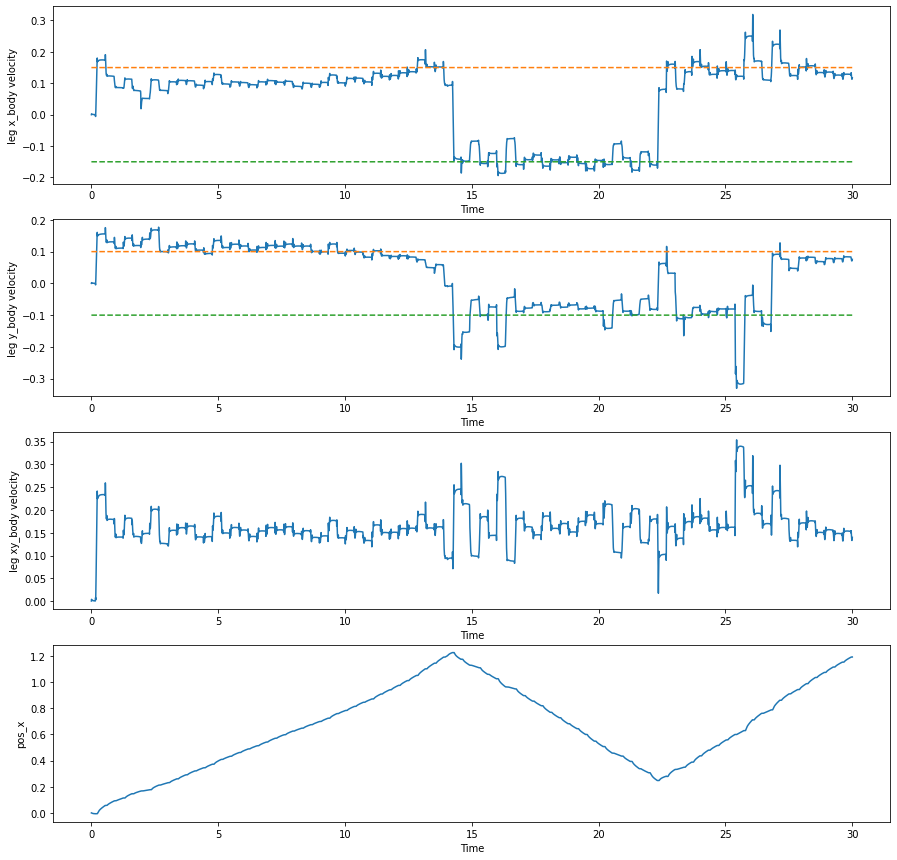

In [16]:
#caculate the real time to the world
Time = np.linspace(0,count*dt,count)

desried_x_dot = np.zeros((count)) + targetVelocity[0]
desried_y_dot = np.zeros((count)) + targetVelocity[1]


# plotting game
plt.figure(figsize = (15, 15))

plt.subplot(4,1,1)
plt.plot(Time, leg_state['vel_x_body'])
plt.plot(Time, desried_x_dot,'--')
plt.plot(Time, -desried_x_dot,'--')
plt.xlabel('Time')
plt.ylabel('leg x_body velocity')

plt.subplot(4,1,2)
plt.plot(Time, leg_state['vel_y_body'])
plt.plot(Time, desried_y_dot,'--')
plt.plot(Time, -desried_y_dot,'--')
plt.xlabel('Time')
plt.ylabel('leg y_body velocity')

x_array_body_vel = np.array(leg_state['vel_x_body'])
y_array_body_vel = np.array(leg_state['vel_y_body'])

plt.subplot(4,1,3)
plt.plot(Time, (x_array_body_vel**2 + y_array_body_vel**2)**0.5)
plt.xlabel('Time')
plt.ylabel('leg xy_body velocity')


plt.subplot(4,1,4)
# plt.plot(Time, leg_state['pos'])
plt.plot(Time, Body['pos_on_x'])
plt.xlabel('Time')
plt.ylabel('pos_x')

error: Not connected to physics server.

In [17]:
posxx

1.1922818965842583

In [18]:
state_sample[0]

(-0.00029999970000030003, 1.3877787807814457e-17, 0.10000029999970003)

In [19]:
state_sample[1]

(1.1922818965842583, 0.4672271265430387, 0.01885038938659933)